# Multimodal Animal Transport Mode Planning

This notebook implements an end-to-end multimodal AI pipeline:

1. **Deterministic rule engine** for animal transport mode planning.
2. **Synthetic dataset generation** for instruction tuning.
3. **LoRA fine-tuning** of a Qwen-style 3B LLM on JSON-structured outputs.
4. **Vision-language front-end** using a Qwen-VL model to infer animal attributes from images.
5. **Full pipeline:** image → attributes → distance → JSON transport plan.


## 0. Environment Setup

Uncomment and run the cell below if you need to install dependencies in a fresh environment.


In [1]:
# If running in a fresh environment, uncomment and run these installs once.
# You may want to pin versions compatible with your CUDA / PyTorch setup.

# !pip install -U "torch" "torchvision" "torchaudio" --index-url https://download.pytorch.org/whl/cu121
# !pip install -U transformers accelerate peft datasets pillow tqdm


## 1. Imports and Global Configuration


In [2]:
import os
import math
import json
import random
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Tuple

import torch
from torch.utils.data import Dataset

from datasets import Dataset as HFDataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)

from peft import LoraConfig, get_peft_model

from PIL import Image
from tqdm.auto import tqdm

# Ensure reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Model names (adapt as needed)
VLM_MODEL_NAME = "Qwen/Qwen2.5-VL-3B-Instruct"   # or another Qwen-VL variant
LLM_BASE_NAME = "Qwen/Qwen2.5-3B-Instruct"

# Paths
OUTPUT_DIR = "./animal_transport_lora"
os.makedirs(OUTPUT_DIR, exist_ok=True)


/home/user/miniconda3/envs/animal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Rule Engine and Haversine Distance

The rule engine encodes allowed / disallowed transport modes and travel time computation.


In [3]:
# --- Transport mode definitions and config ---

TRANSPORT_MODES = [
    "car_cabin",
    "car_crate",
    "van_cargo",
    "truck_livestock",
    "bus_cabin",
    "train_cabin",
    "train_cargo",
    "plane_cabin",
    "plane_cargo",
    "specialized_animal_freight",
]

# Approximate average speeds (km/h)
MODE_SPEED_KMH = {
    "car_cabin": 80,
    "car_crate": 80,
    "van_cargo": 70,
    "truck_livestock": 60,
    "bus_cabin": 70,
    "train_cabin": 100,
    "train_cargo": 80,
    "plane_cabin": 800,
    "plane_cargo": 800,
    "specialized_animal_freight": 65,
}

# Fixed handling overhead (hours)
MODE_OVERHEAD_H = {
    "car_cabin": 0.25,
    "car_crate": 0.5,
    "van_cargo": 0.5,
    "truck_livestock": 1.0,
    "bus_cabin": 0.5,
    "train_cabin": 0.5,
    "train_cargo": 1.0,
    "plane_cabin": 2.5,
    "plane_cargo": 4.0,
    "specialized_animal_freight": 2.0,
}


def haversine_distance_km(lat1, lon1, lat2, lon2) -> float:
    """Compute Haversine distance between two coordinates (in degrees)."""
    R = 6371.0  # Earth radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = (
        math.sin(dphi / 2) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c


def estimate_travel_time_hours(distance_km: float, mode: str) -> float:
    v = MODE_SPEED_KMH[mode]
    overhead = MODE_OVERHEAD_H[mode]
    return distance_km / v + overhead


### Rule Constraints

We define constraints based on:

- `animal_category`: small_pet, medium_pet, large_livestock, bird, reptile, wild_dangerous  
- `size_class`: small, medium, large  
- `is_domesticated`: bool  
- `dangerous_to_humans`: bool  
- `distance_km`: float


In [4]:
!nvidia-smi

Mon Nov 24 07:02:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB            Off| 00000000:00:05.0 Off |                    0 |
| N/A   27C    P0               24W / 300W|      7MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
ANIMAL_CATEGORIES = [
    "small_pet",
    "medium_pet",
    "large_livestock",
    "bird",
    "reptile",
    "wild_dangerous",
]

SIZE_CLASSES = ["small", "medium", "large"]


def constraints_satisfied(
    animal_category: str,
    size_class: str,
    is_domesticated: bool,
    dangerous_to_humans: bool,
    distance_km: float,
    mode: str,
) -> bool:
    """Hand-crafted constraints for allowed transport modes."""
    # Wild or dangerous animals: NO passenger cabins of public transport
    if dangerous_to_humans or animal_category == "wild_dangerous":
        if mode in {"bus_cabin", "train_cabin", "plane_cabin", "car_cabin"}:
            return False

    # Very long distances -> prefer air or specialized freight
    if distance_km > 1500:
        if mode in {"car_cabin", "car_crate", "van_cargo", "truck_livestock", "bus_cabin"}:
            return False

    # Large livestock: require truck_livestock or plane_cargo / specialized freight
    if animal_category == "large_livestock":
        if mode not in {"truck_livestock", "plane_cargo", "specialized_animal_freight"}:
            return False

    # Small pets: can be in cabin (car, bus, train, plane) for shorter trips
    if animal_category == "small_pet" and not dangerous_to_humans:
        if distance_km <= 1200:
            if mode in {"car_cabin", "bus_cabin", "train_cabin", "plane_cabin", "car_crate"}:
                return True

    # Birds: typically crate + cabin for short trips, cargo for long trips
    if animal_category == "bird":
        if distance_km <= 1000:
            if mode in {"car_crate", "plane_cabin", "train_cargo"}:
                return True
        else:
            if mode in {"plane_cargo", "specialized_animal_freight"}:
                return True

    # Reptiles: crate only, and no passenger cabins for long trips
    if animal_category == "reptile":
        if distance_km <= 500:
            if mode in {"car_crate", "van_cargo"}:
                return True
        if mode in {"plane_cargo", "specialized_animal_freight"} and distance_km > 500:
            return True
        if mode in {"bus_cabin", "train_cabin", "plane_cabin"}:
            return False

    # Medium pets (dogs/cats etc.)
    if animal_category == "medium_pet" and not dangerous_to_humans:
        if distance_km <= 800:
            if mode in {"car_cabin", "car_crate", "bus_cabin", "train_cabin"}:
                return True
        if mode in {"train_cargo", "plane_cargo"} and distance_km > 800:
            return True

    # Default safety rules:
    # - Specialized freight always allowed for non-extreme cases
    if mode == "specialized_animal_freight":
        return True

    # Fallback: disallow if no positive rule triggered
    return False


def generate_transport_plan(
    animal_category: str,
    size_class: str,
    is_domesticated: bool,
    dangerous_to_humans: bool,
    distance_km: float,
) -> Dict[str, Any]:
    """Generate allowed/disallowed modes and reasoning string."""
    allowed_modes = []
    disallowed_modes = []

    for m in TRANSPORT_MODES:
        if constraints_satisfied(
            animal_category, size_class, is_domesticated, dangerous_to_humans, distance_km, m
        ):
            allowed_modes.append(m)
        else:
            disallowed_modes.append(m)

    # Simple textual reasoning:
    reasons = []
    if dangerous_to_humans or animal_category == "wild_dangerous":
        reasons.append(
            "Dangerous or wild animals are not permitted in passenger cabins of public transport."
        )
    if animal_category == "large_livestock":
        reasons.append(
            "Large livestock require trucks, plane cargo, or specialized animal freight."
        )
    if animal_category in {"small_pet", "medium_pet"} and not dangerous_to_humans:
        reasons.append(
            "Small and medium domesticated pets may travel in cabins for short distances; "
            "long distances prefer cargo or specialized options."
        )
    if animal_category == "bird":
        reasons.append(
            "Birds typically travel in crates; short trips may use cabin or train cargo, "
            "while long trips require air cargo or specialized freight."
        )
    if animal_category == "reptile":
        reasons.append(
            "Reptiles must travel in secure crates, often in cargo or specialized vehicles."
        )
    if distance_km > 1500:
        reasons.append(
            "Long-distance travel favors air transport or specialized freight due to time and welfare."
        )

    reasoning = " ".join(reasons) if reasons else "Standard welfare and safety rules applied."

    # Add simple travel time estimates for allowed modes
    travel_times = {
        m: round(estimate_travel_time_hours(distance_km, m), 2) for m in allowed_modes
    }

    plan = {
        "available_modes": allowed_modes,
        "disallowed_modes": disallowed_modes,
        "distance_km": round(distance_km, 1),
        "estimated_travel_time_hours": travel_times,
        "reasoning": reasoning,
    }
    return plan


## 3. Synthetic Dataset Generation

We generate synthetic problems with random animal attributes and origin/destination pairs.
Ground-truth JSON transport plans are obtained from the rule engine.


In [6]:
SYSTEM_PROMPT = """You are an expert assistant for animal transport mode planning.
Given an animal profile and a travel distance, you must output a JSON object
describing allowed and disallowed transport modes and a short reasoning string.

Follow this JSON schema exactly:

{
  "available_modes": [string, ...],
  "disallowed_modes": [string, ...],
  "distance_km": number,
  "estimated_travel_time_hours": {string: number, ...},
  "reasoning": string
}

Do not add extra keys. Do not output anything outside the JSON (no markdown, no comments).
"""


In [7]:


@dataclass
class AnimalExample:
    animal_category: str
    size_class: str
    is_domesticated: bool
    dangerous_to_humans: bool
    origin_lat: float
    origin_lon: float
    dest_lat: float
    dest_lon: float
    distance_km: float
    plan: Dict[str, Any]


def random_coord():
    # Roughly realistic lat/lon
    lat = random.uniform(-60, 60)
    lon = random.uniform(-170, 170)
    return lat, lon


def generate_synthetic_example() -> AnimalExample:
    animal_category = random.choice(ANIMAL_CATEGORIES)
    size_class = random.choice(SIZE_CLASSES)

    # Simple heuristics for flags
    if animal_category in {"wild_dangerous", "reptile"}:
        is_domesticated = False
    else:
        is_domesticated = random.random() < 0.9

    if animal_category == "wild_dangerous":
        dangerous_to_humans = True
    elif animal_category == "reptile":
        dangerous_to_humans = random.random() < 0.4
    else:
        dangerous_to_humans = random.random() < 0.1

    lat1, lon1 = random_coord()
    lat2, lon2 = random_coord()
    distance_km = haversine_distance_km(lat1, lon1, lat2, lon2)

    plan = generate_transport_plan(
        animal_category,
        size_class,
        is_domesticated,
        dangerous_to_humans,
        distance_km,
    )

    return AnimalExample(
        animal_category=animal_category,
        size_class=size_class,
        is_domesticated=is_domesticated,
        dangerous_to_humans=dangerous_to_humans,
        origin_lat=lat1,
        origin_lon=lon1,
        dest_lat=lat2,
        dest_lon=lon2,
        distance_km=distance_km,
        plan=plan,
    )


def example_to_input_json(ex: AnimalExample) -> Dict[str, Any]:
    return {
        "animal_category": ex.animal_category,
        "size_class": ex.size_class,
        "is_domesticated": ex.is_domesticated,
        "dangerous_to_humans": ex.dangerous_to_humans,
        "origin": {"lat": round(ex.origin_lat, 4), "lon": round(ex.origin_lon, 4)},
        "destination": {"lat": round(ex.dest_lat, 4), "lon": round(ex.dest_lon, 4)},
        "distance_km": round(ex.distance_km, 1),
    }


def generate_dataset(num_samples: int) -> List[Dict[str, Any]]:
    data = []
    for _ in tqdm(range(num_samples), desc="Generating synthetic examples"):
        ex = generate_synthetic_example()
        inp = example_to_input_json(ex)
        out = ex.plan
        data.append({"input": inp, "label": out})
    return data


### Generate Train / Validation Split


In [8]:
NUM_TRAIN = 800   # you can increase if you have GPU capacity
NUM_VAL = 200

full_data = generate_dataset(NUM_TRAIN + NUM_VAL)
train_data = full_data[:NUM_TRAIN]
val_data = full_data[NUM_TRAIN:NUM_TRAIN + NUM_VAL]

len(train_data), len(val_data)


Generating synthetic examples: 100%|██████████| 1000/1000 [00:00<00:00, 53440.15it/s]


(800, 200)

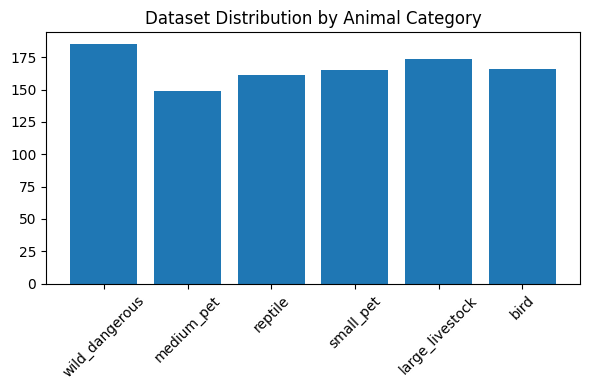

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

cats = [d["input"]["animal_category"] for d in full_data]
sizes = [d["input"]["size_class"] for d in full_data]
distances = [d["input"]["distance_km"] for d in full_data]

plt.figure(figsize=(6,4))
plt.bar(Counter(cats).keys(), Counter(cats).values())
plt.title("Dataset Distribution by Animal Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/dataset_distribution.png")
plt.show()


## 4. Prepare Tokenizer and LLM with LoRA


In [10]:
tokenizer = AutoTokenizer.from_pretrained(LLM_BASE_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    LLM_BASE_NAME,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None,
    trust_remote_code=True,
)

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]


trainable params: 3,686,400 || all params: 3,089,625,088 || trainable%: 0.1193


## 5. Build Hugging Face Datasets with Chat Templates


In [11]:
def build_hf_dataset(data: List[Dict[str, Any]]) -> HFDataset:
    return HFDataset.from_list(data)


hf_train = build_hf_dataset(train_data)
hf_val = build_hf_dataset(val_data)

def format_example(example: Dict[str, Any]) -> Dict[str, Any]:
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": json.dumps(example["input"], indent=2)},
        {"role": "assistant", "content": json.dumps(example["label"], indent=2)},
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,
    )
    tokenized = tokenizer(text, truncation=True, max_length=1024)
    input_ids = tokenized["input_ids"]
    labels = input_ids.copy()
    return {
        "input_ids": input_ids,
        "attention_mask": tokenized["attention_mask"],
        "labels": labels,
    }

hf_train_tok = hf_train.map(
    format_example,
    batched=False,
    remove_columns=hf_train.column_names,
)
hf_val_tok = hf_val.map(
    format_example,
    batched=False,
    remove_columns=hf_val.column_names,
)


Map: 100%|██████████| 200/200 [00:00<00:00, 581.10 examples/s]


### Data Collator


In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)


## 6. Evaluation Utilities + Evaluation pre-training the model + Train the LoRA-Adapted LLM


In [13]:
torch.cuda.empty_cache()

In [14]:
def safe_json_loads(s: str) -> Any:
    try:
        return json.loads(s)
    except Exception:
        return None

def evaluate_on_dataset_subset(
    dataset_subset,
    temperature: float = 0.1,
):
    model.eval()
    correct_exact = 0
    json_valid = 0
    schema_ok = 0
    n = len(dataset_subset)

    for i in tqdm(range(n), desc="Eval"):
        sample = dataset_subset[i]
        input_obj = sample["input"]
        true_plan = sample["label"]

        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": json.dumps(input_obj, indent=2)},
        ]

        prompt = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
        )

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            gen_ids = model.generate(
                **inputs,
                max_new_tokens=512,
                do_sample=True,
                temperature=temperature,
            )

        gen_text = tokenizer.decode(
            gen_ids[0][inputs["input_ids"].shape[1]:],
            skip_special_tokens=True,
        ).strip()

        if "{" in gen_text and "}" in gen_text:
            gen_text = gen_text[gen_text.find("{"): gen_text.rfind("}")+1]

        obj = safe_json_loads(gen_text)
        if obj is not None:
            json_valid += 1
            expected_keys = {
                "available_modes",
                "disallowed_modes",
                "distance_km",
                "estimated_travel_time_hours",
                "reasoning",
            }
            if set(obj.keys()) == expected_keys:
                schema_ok += 1

            if (
                set(obj["available_modes"]) == set(true_plan["available_modes"])
                and set(obj["disallowed_modes"]) == set(true_plan["disallowed_modes"])
            ):
                correct_exact += 1

    return {
        "json_valid_rate": json_valid / n,
        "schema_ok_rate": schema_ok / n,
        "exact_match_rate": correct_exact / n,
    }
# Fix evaluation subset to guarantee identical samples before & after training
EVAL_SAMPLES = 10  # or any number you want
random.seed(123)   # fixed seed for reproducibility

eval_indices = random.sample(range(len(val_data)), EVAL_SAMPLES)
eval_subset = [val_data[i] for i in eval_indices]

len(eval_subset), eval_subset[0]


(10,
 {'input': {'animal_category': 'wild_dangerous',
   'size_class': 'small',
   'is_domesticated': False,
   'dangerous_to_humans': True,
   'origin': {'lat': -24.1356, 'lon': -37.3644},
   'destination': {'lat': -47.1878, 'lon': 64.2065},
   'distance_km': 8883.2},
  'label': {'available_modes': ['specialized_animal_freight'],
   'disallowed_modes': ['car_cabin',
    'car_crate',
    'van_cargo',
    'truck_livestock',
    'bus_cabin',
    'train_cabin',
    'train_cargo',
    'plane_cabin',
    'plane_cargo'],
   'distance_km': 8883.2,
   'estimated_travel_time_hours': {'specialized_animal_freight': 138.66},
   'reasoning': 'Dangerous or wild animals are not permitted in passenger cabins of public transport. Long-distance travel favors air transport or specialized freight due to time and welfare.'}})

In [15]:
from transformers import TrainerCallback
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.loss_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.loss_history.append((state.global_step, logs["loss"]))

loss_logger = LossLoggerCallback()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The model is already on multiple devices. Skipping the move to device specified in `args`.


Evaluating BASE (no training) model on fixed subset...


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

Eval: 100%|██████████| 10/10 [01:28<00:00,  8.80s/it]


Step,Training Loss
1,2.199200
2,2.031700
3,1.811100
4,1.718100
5,1.642900
6,1.595300
7,1.524800
8,1.458400
9,1.425800
10,1.368900


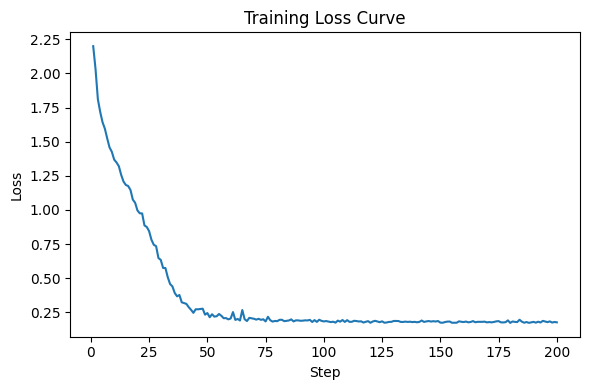

In [16]:
import os
from transformers import TrainingArguments, Trainer

# Hard-disable Weights & Biases so it never prompts for an API key
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

# Optional: also silence some HF telemetry/warnings
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=2e-4,
    logging_steps=1,
    # NOTE:
    # - We intentionally omit evaluation_strategy / eval_steps / save_steps / save_total_limit
    #   for compatibility with older transformers versions.
    # - If your version supports fp16/bf16 and report_to/remove_unused_columns,
    #   you can re-add them here.
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    data_collator=data_collator,
    callbacks=[loss_logger], 
)

print("Evaluating BASE (no training) model on fixed subset...")
base_eval_metrics = evaluate_on_dataset_subset(eval_subset)
base_eval_metrics




trainer.train()
trainer.save_model(OUTPUT_DIR)

steps, losses = zip(*loss_logger.loss_history)

plt.figure(figsize=(6,4))
plt.plot(steps, losses)
plt.title("Training Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("figures/training_loss.png", dpi=300)
plt.show()


## 7. Evaluation (JSON Validity, Schema Compliance, Task Accuracy)


In [17]:
print("Evaluating TRAINED model on the same fixed subset...")
trained_eval_metrics = evaluate_on_dataset_subset(eval_subset)
trained_eval_metrics


Evaluating TRAINED model on the same fixed subset...


Eval: 100%|██████████| 10/10 [03:10<00:00, 19.04s/it]


{'json_valid_rate': 1.0, 'schema_ok_rate': 1.0, 'exact_match_rate': 0.8}

In [18]:
import pandas as pd

comparison_df = pd.DataFrame({
    "metric": list(base_eval_metrics.keys()),
    "before_training": list(base_eval_metrics.values()),
    "after_training": list(trained_eval_metrics.values()),
})

comparison_df


,metric,before_training,after_training
0,json_valid_rate,1.0,1.0
1,schema_ok_rate,1.0,1.0
2,exact_match_rate,0.0,0.8


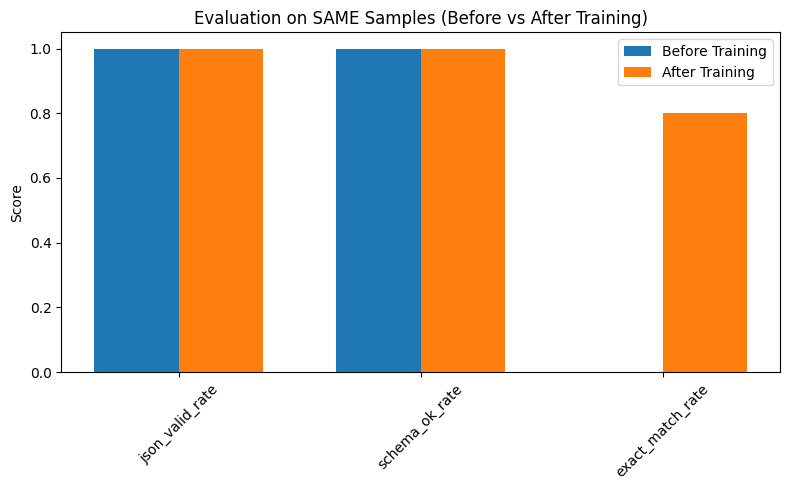

In [19]:
import matplotlib.pyplot as plt
import numpy as np

metrics = list(base_eval_metrics.keys())
before = list(base_eval_metrics.values())
after = list(trained_eval_metrics.values())

x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, before, width=w, label="Before Training")
plt.bar(x + w/2, after, width=w, label="After Training")
plt.xticks(x, metrics, rotation=45)
plt.ylabel("Score")
plt.title("Evaluation on SAME Samples (Before vs After Training)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/eval_same_samples_before_after.png", dpi=300)
plt.show()


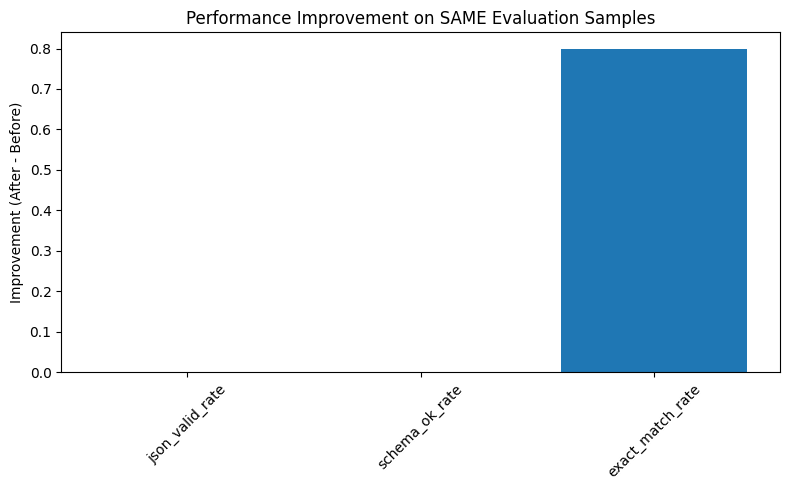

In [20]:
improvement = [a - b for a, b in zip(after, before)]

plt.figure(figsize=(8,5))
plt.bar(metrics, improvement)
plt.xticks(rotation=45)
plt.ylabel("Improvement (After - Before)")
plt.title("Performance Improvement on SAME Evaluation Samples")
plt.tight_layout()
plt.savefig("figures/eval_improvement_same_samples.png", dpi=300)
plt.show()


## 8. Vision-Language Front-End (Qwen-VL)


In [21]:
torch.cuda.empty_cache()

In [22]:
from transformers import AutoProcessor, AutoModelForVision2Seq

# vlm_processor = AutoProcessor.from_pretrained(VLM_MODEL_NAME, trust_remote_code=True)
# vlm_model = AutoModelForVision2Seq.from_pretrained(
#     VLM_MODEL_NAME,
#     # torch_dtype=torch.float16,
#     load_in_4bit=True,
#     device_map="cuda",
#     trust_remote_code=True,
# )


In [23]:
import json
import torch
from PIL import Image

def extract_json_block(text: str):
    """
    Extract the FIRST valid top-level JSON object from a string.
    No regex with recursion. Works with any VLM output.
    """
    start = text.find("{")
    if start == -1:
        return None

    depth = 0
    for i in range(start, len(text)):
        if text[i] == "{":
            depth += 1
        elif text[i] == "}":
            depth -= 1
            if depth == 0:
                block = text[start : i + 1]
                return block

    return None


def extract_animal_attributes_from_image(image_path: str) -> Dict[str, Any]:
    img = Image.open(image_path).convert("RGB")
    img = img.resize((256, 256), Image.LANCZOS)

    prompt = (
        "Analyze the provided animal image.\n"
        "Return ONLY valid JSON with EXACT keys:\n"
        "animal_name, animal_category, size_class, is_domesticated, dangerous_to_humans."
    )

    # → Multimodal chat (correct for Vision2Seq)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text",  "text": prompt},
            ],
        }
    ]

    text = vlm_processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    # Encode multimodal input
    inputs = vlm_processor(
        text=[text],
        images=[img],
        return_tensors="pt"
    )

    # Move to GPU
    for k, v in inputs.items():
        if torch.is_tensor(v):
            inputs[k] = v.to("cuda")

    # Generate
    with torch.no_grad():
        output = vlm_model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.0,
            do_sample=False
        )

    decoded = vlm_processor.batch_decode(output, skip_special_tokens=True)[0]

    # Extract JSON cleanly
    json_block = extract_json_block(decoded)
    if json_block is None:
        print("[VLM RAW OUTPUT]:\n", decoded)
        raise ValueError("Failed to extract JSON from VLM output.")

    attrs = json.loads(json_block)

    # Defaults
    attrs.setdefault("animal_name", "unknown")
    attrs.setdefault("animal_category", "wild_dangerous")
    attrs.setdefault("size_class", "large")
    attrs["is_domesticated"] = bool(attrs.get("is_domesticated", False))
    attrs["dangerous_to_humans"] = bool(attrs.get("dangerous_to_humans", True))

    return attrs


## 9. Full Pipeline: Image → Attributes → Distance → JSON Transport Plan


In [24]:
torch.cuda.empty_cache()

In [25]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Nov 24 07:10:47 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB            Off| 00000000:00:05.0 Off |                    0 |
| N/A   31C    P0               45W / 300W|   7055MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
## 9.VLM-1 — Import and initialize VLM

import base64
import sys

# Make sure project module can be imported
sys.path.insert(0, "src")

from animal_transport.api.inference_vlm import get_vlm_wrapper

# Initialize VLM instance
vlm = get_vlm_wrapper()


[VLM] Using device: cuda
[VLM] Loading processor...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!


[VLM] Loading model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.47s/it]


In [27]:
## 9.VLM-2 — Analyze a single image with the VLM

def run_vlm_on_image(image_path: str):
    # Load image → base64 string
    with open(image_path, "rb") as f:
        img_base64 = base64.b64encode(f.read()).decode()

    # Call your VLM wrapper
    result = vlm.analyze_animal(img_base64)

    print("\n[VLM Output JSON]:")
    print(result)
    return result
## 10.2 — LLM Transport Planner (JSON-in → JSON-out)

import json
import torch

def run_llm_planner(vlm_json: dict, temperature: float = 0.1):
    """
    Given the VLM JSON attributes, ask the fine-tuned LLM to produce a transport plan.
    Assumes SYSTEM_PROMPT, tokenizer, model, safe_json_loads exist globally.
    """

    # The LLM expects exactly this input format:
    user_input = {
        "animal_category": vlm_json["animal_category"],
        "size_class": vlm_json["size_class"],
        "is_domesticated": vlm_json["is_domesticated"],
        "dangerous_to_humans": vlm_json["dangerous_to_humans"],
        # Put dummy coords + distance (the planner needs them)
        "origin": {"lat": 10.0, "lon": 10.0},
        "destination": {"lat": 20.0, "lon": 20.0},
        "distance_km": 150.0
    }

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": json.dumps(user_input, indent=2)},
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=True,
            temperature=temperature,
        )

    gen_text = tokenizer.decode(
        out[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    # Extract JSON
    if "{" in gen_text and "}" in gen_text:
        js = gen_text[gen_text.find("{") : gen_text.rfind("}")+1]
    else:
        js = gen_text

    parsed = safe_json_loads(js)

    print("\n[LLM → Transport Plan]:")
    if parsed:
        print(json.dumps(parsed, indent=2))
    else:
        print("⚠️ Not valid JSON\nRaw output:")
        print(gen_text)

    return parsed, gen_text


In [28]:
## 10.3 — Full Pipeline on One Image

image_path = "tests/tiger.jpg"   # change as needed

# Step 1 — VLM
vlm_json = run_vlm_on_image(image_path)

# Step 2 — LLM
plan_json, raw = run_llm_planner(vlm_json)



[VLM Output JSON]:
{'animal_name': 'tiger', 'animal_category': 'wild', 'size_class': 'large', 'is_domesticated': False, 'dangerous_to_humans': True}

[LLM → Transport Plan]:
{
  "available_modes": [
    "specialized_animal_freight"
  ],
  "disallowed_modes": [
    "car_cabin",
    "car_crate",
    "van_cargo",
    "truck_livestock",
    "bus_cabin",
    "train_cabin",
    "train_cargo",
    "plane_cabin",
    "plane_cargo"
  ],
  "distance_km": 150.0,
  "estimated_travel_time_hours": {
    "bus_cabin": null,
    "car_cabin": null,
    "car_crate": null,
    "plane_cabin": null,
    "plane_cargo": null,
    "specialized_animal_freight": 2.48,
    "train_cabin": null,
    "train_cargo": null
  },
  "reasoning": "Dangerous or wild animals are not permitted in passenger cabins of public transport. Long-distance travel favors air transport or specialized freight due to time and welfare."
}


## 10. Summary

This notebook implements:

- A deterministic rule system for animal transport modes.  
- Synthetic instruction-tuning data generation using that rule system.  
- LoRA fine-tuning of a Qwen-style 3B LLM for JSON-structured outputs.  
- A Qwen-VL-based front-end that infers animal attributes from images.  
- A full pipeline from image to finalized JSON transport plan.

You can now:
- Adjust the rules in the rule engine for your domain.
- Increase dataset size and training epochs for better performance.
- Replace model names with local / smaller variants if your hardware is limited.
